# Проект по анализу данных с сайта Science Daily

### Часть 1.1
### Реализация парсера

In [60]:
%%capture
!pip install selenium
!pip install fake_useragent

In [109]:
import re
import time
import json
import datetime
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
from selenium import webdriver
from dataclasses import dataclass
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from fake_useragent import UserAgent

In [3]:
SLEEP = lambda: np.random.choice([3, 5, 7, 10])
BASE_URL = "https://www.sciencedaily.com"
TOP_NEWS = "/news/top/"
TOPICS = ["health", "technology", "environment", "society"]

In [4]:
@dataclass
class Article:
    url: str = None
    title: str = None
    content: str = None
    date: str = None
    source: str = None
    topic: str = None

In [5]:
# Create a Selenium web driver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("headless")
chrome_options.add_argument("no-sandbox")
chrome_options.add_argument("disable-dev-shm-usage")
custom_user_agent = UserAgent().chrome
chrome_options.add_argument(f"user-agent={custom_user_agent}")

driver = webdriver.Chrome(options=chrome_options)

In [6]:
# Define a function to load more stories
def load_more_stories(driver, num_clicks=5):
    for _ in range(num_clicks):
        try:
            # Find and click the "Load more stories" button
            load_more_button = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.ID, "load_more_stories"))
            )
            load_more_button.click()
        except Exception as e:
            pass
            # # Handle any exceptions, e.g., if the button is not found
            # print(f"Error loading more stories: {str(e)}")

In [9]:
def get_items(topic):

    URL = BASE_URL + TOP_NEWS + topic

    # Navigate to the initial page
    driver.get(URL)
    time.sleep(SLEEP())

    # Load more stories using Selenium
    load_more_stories(driver, num_clicks=10)

    # Get the updated page source
    html = driver.page_source

    # Parse the HTML source with BeautifulSoup
    soup = BeautifulSoup(html, "html.parser")
    scope = soup.find_all("div", {"class": "tab-content"})
    items = []
    for item in scope:
        items.extend(item.find_all("a"))

    return items

In [8]:
def parse_item(item, topic):
    """Extract from page desired fields"""

    # Create article data class object
    article = Article()

    # article url
    article.url = BASE_URL + item["href"]

    # article title
    article.title = item.text

    # load page
    driver.get(article.url)
    time.sleep(SLEEP())
    html = driver.page_source

    soup = BeautifulSoup(html, "html.parser")
    scope = soup.find("div", {"id": "story_text"})

    # article content
    content = scope.get_text().replace("advertisement", "").strip()
    content = re.sub(r"\n+", " ", content)
    article.content = content

    # article date
    article.date = soup.find("dd", {"id": "date_posted"}).text

    # article source
    article.source = soup.find("dd", {"id": "source"}).text

    # article topic
    article.topic = topic

    return article

In [ ]:
data = []
for topic in tqdm(TOPICS):
    items = get_items(topic)
    for item in tqdm(items):
        try:
            res = parse_item(item, topic)
            data.append(res)
        except:
            pass

driver.quit()

  0%|          | 0/4 [00:00<?, ?it/s]

https://www.sciencedaily.com/news/top/health



 25%|██▌       | 1/4 [35:59<1:47:59, 2159.88s/it]

https://www.sciencedaily.com/news/top/technology



 50%|█████     | 2/4 [1:09:48<1:09:24, 2082.39s/it]

https://www.sciencedaily.com/news/top/environment



 75%|███████▌  | 3/4 [1:47:01<35:51, 2151.21s/it]  

https://www.sciencedaily.com/news/top/society



100%|██████████| 4/4 [2:23:34<00:00, 2153.57s/it]


In [ ]:
df = pd.DataFrame(data=data)
df.head()

url  \
0  https://www.sciencedaily.com/releases/2023/10/...   
1  https://www.sciencedaily.com/releases/2023/10/...   
2  https://www.sciencedaily.com/releases/2023/10/...   
3  https://www.sciencedaily.com/releases/2023/10/...   
4  https://www.sciencedaily.com/releases/2023/10/...   

                                               title  \
0  Even Treated Wood Prevents Bacterial Transmiss...   
1  Mobile Stroke Units Increase Odds of Averting ...   
2  Cutting-Edge Imaging Sheds New Light on Cells ...   
3  More Accurate Identification of Children at Hi...   
4  Most Forms of Exercise Are Overwhelmingly Safe...   

                                             content              date  \
0  According to a Finnish study, surface treatmen...  October 26, 2023   
1  Receiving a clot-busting drug in an ambulance-...  October 26, 2023   
2  Cutting-edge imaging sheds new light on cells ...  October 26, 2023   
3  A new study helps to identify children who are...  October 26, 2023   
4  The risks of serious injury from most sports a...  October 26, 2023   

                                 source   topic  
0                University of Helsinki  health  
1                Weill Cornell Medicine  health  
2  Garvan Institute of Medical Research  health  
3                University of Helsinki  health  
4                    University of Bath  health

In [ ]:
df.to_pickle("df_final.p", compression="gzip")

In [ ]:
excel_file_path = "output.xlsx"

# Convert the DataFrame to an Excel file
df.to_excel(excel_file_path, index=False)

---

### Часть 1.2
### Первичный анализ данных

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Основные описательные статистики + визуальный анализ данных. Важно отметить интересные моменты в ваших данных до проведения исследования:
- определить особенности выборки по результатам первичного анализ, удаление выбросов и т.д.
- отметить моменты, которые позволят до проведения расчетов и построения моделей, выдвинуть несколько гипотез/предположений о результатах следующих этапов и т.д.
---

- Распределение категорий
- Распределение времени новостей
- Распределение просмотров
- Распределение по длине заголовка
- Распределение по длине текста
- Распределение просмотров в по топикам
- Ключевые слова по каждой из тематик

In [89]:
df = pd.read_pickle("df_final.p", compression="gzip")

In [90]:
df.head()

url  \
0  https://www.sciencedaily.com/releases/2023/10/...   
1  https://www.sciencedaily.com/releases/2023/10/...   
2  https://www.sciencedaily.com/releases/2023/10/...   
3  https://www.sciencedaily.com/releases/2023/10/...   
4  https://www.sciencedaily.com/releases/2023/10/...   

                                               title  \
0  Even Treated Wood Prevents Bacterial Transmiss...   
1  Mobile Stroke Units Increase Odds of Averting ...   
2  Cutting-Edge Imaging Sheds New Light on Cells ...   
3  More Accurate Identification of Children at Hi...   
4  Most Forms of Exercise Are Overwhelmingly Safe...   

                                             content              date  \
0  According to a Finnish study, surface treatmen...  October 26, 2023   
1  Receiving a clot-busting drug in an ambulance-...  October 26, 2023   
2  Cutting-edge imaging sheds new light on cells ...  October 26, 2023   
3  A new study helps to identify children who are...  October 26, 2023   
4  The risks of serious injury from most sports a...  October 26, 2023   

                                 source   topic  
0                University of Helsinki  health  
1                Weill Cornell Medicine  health  
2  Garvan Institute of Medical Research  health  
3                University of Helsinki  health  
4                    University of Bath  health

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220 entries, 0 to 1219
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      1220 non-null   object
 1   title    1220 non-null   object
 2   content  1220 non-null   object
 3   date     1220 non-null   object
 4   source   1220 non-null   object
 5   topic    1220 non-null   object
dtypes: object(6)
memory usage: 57.3+ KB


In [92]:
df.describe()

url  \
count                                                1220   
unique                                                637   
top     https://www.sciencedaily.com/releases/2023/10/...   
freq                                                    6   

                                                    title  \
count                                                1220   
unique                                                661   
top     Physical Theory Improves Protein Folding Predi...   
freq                                                    6   

                                                  content              date  \
count                                                1220              1220   
unique                                                637                54   
top     Scientists have a new tool to precisely illumi...  October 19, 2023   
freq                                                    6               126   

            source   topic  
count         1220    1220  
unique         318       4  
top     Cell Press  health  
freq            29     310

In [97]:
def deduplicate_group(group):
    return group.drop_duplicates(subset="content", keep="first")


# Group the DataFrame by 'topic' and apply the deduplication function
deduplicated_groups = df.groupby("topic", group_keys=False).apply(deduplicate_group)

# Reset the index and sort by 'topic'
df = deduplicated_groups.reset_index(drop=True)

In [98]:
# Размер каждой категории
df.topic.value_counts()

environment    212
health         212
society        212
technology     191
Name: topic, dtype: int64

In [99]:
df.shape

(827, 6)

Категории сбалансированы. Среди классов все еще есть дубликаты. Количество строк в df - 827 (при этом количество уникальных строк по столбцу "content" - 637).

In [101]:
unique_content_df = df.drop_duplicates(subset=["content"], keep="first")

In [102]:
unique_content_df.topic.value_counts()

environment    212
society        170
health         148
technology     107
Name: topic, dtype: int64

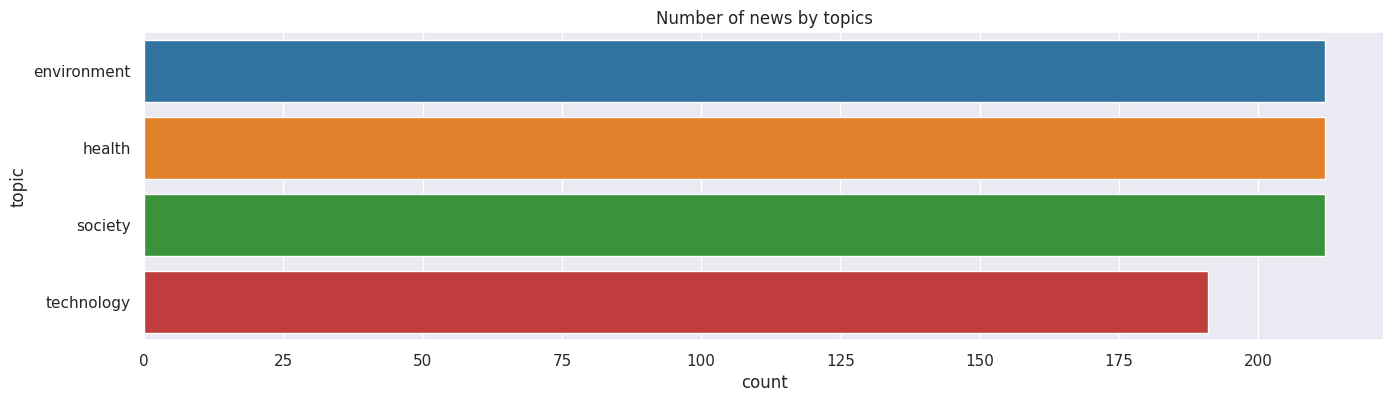

In [16]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16, 4))
sns.countplot(y=df["topic"], palette="tab10", ax=ax)
plt.title("Number of news by topics");

Сама по себе дата как строка не является признаком, однако ее компоненты могут играть важную роль в работе модели. Поэтому мы преобразуем строковую дату в формат datetime и добавим к нашим признакам год, месяц и день недели.

In [103]:
df["date"] = pd.to_datetime(df.date)
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.strftime("%B")
df["weekday"] = df["date"].dt.strftime("%A")

Какие выводы можно сделать по графикам ниже:
- Все новости относятся к 2023 году
- Больше всего новостей приходится на текущий месяц (Октябрь), так как парсинг выполнялся по последним новостям в топе
- В выходные (Суббота, Воскресенье) новости не публикуются
- Количество новостей увеличивается с Понедельника по Четверг (пик), меньше всего новостей в Пятницу

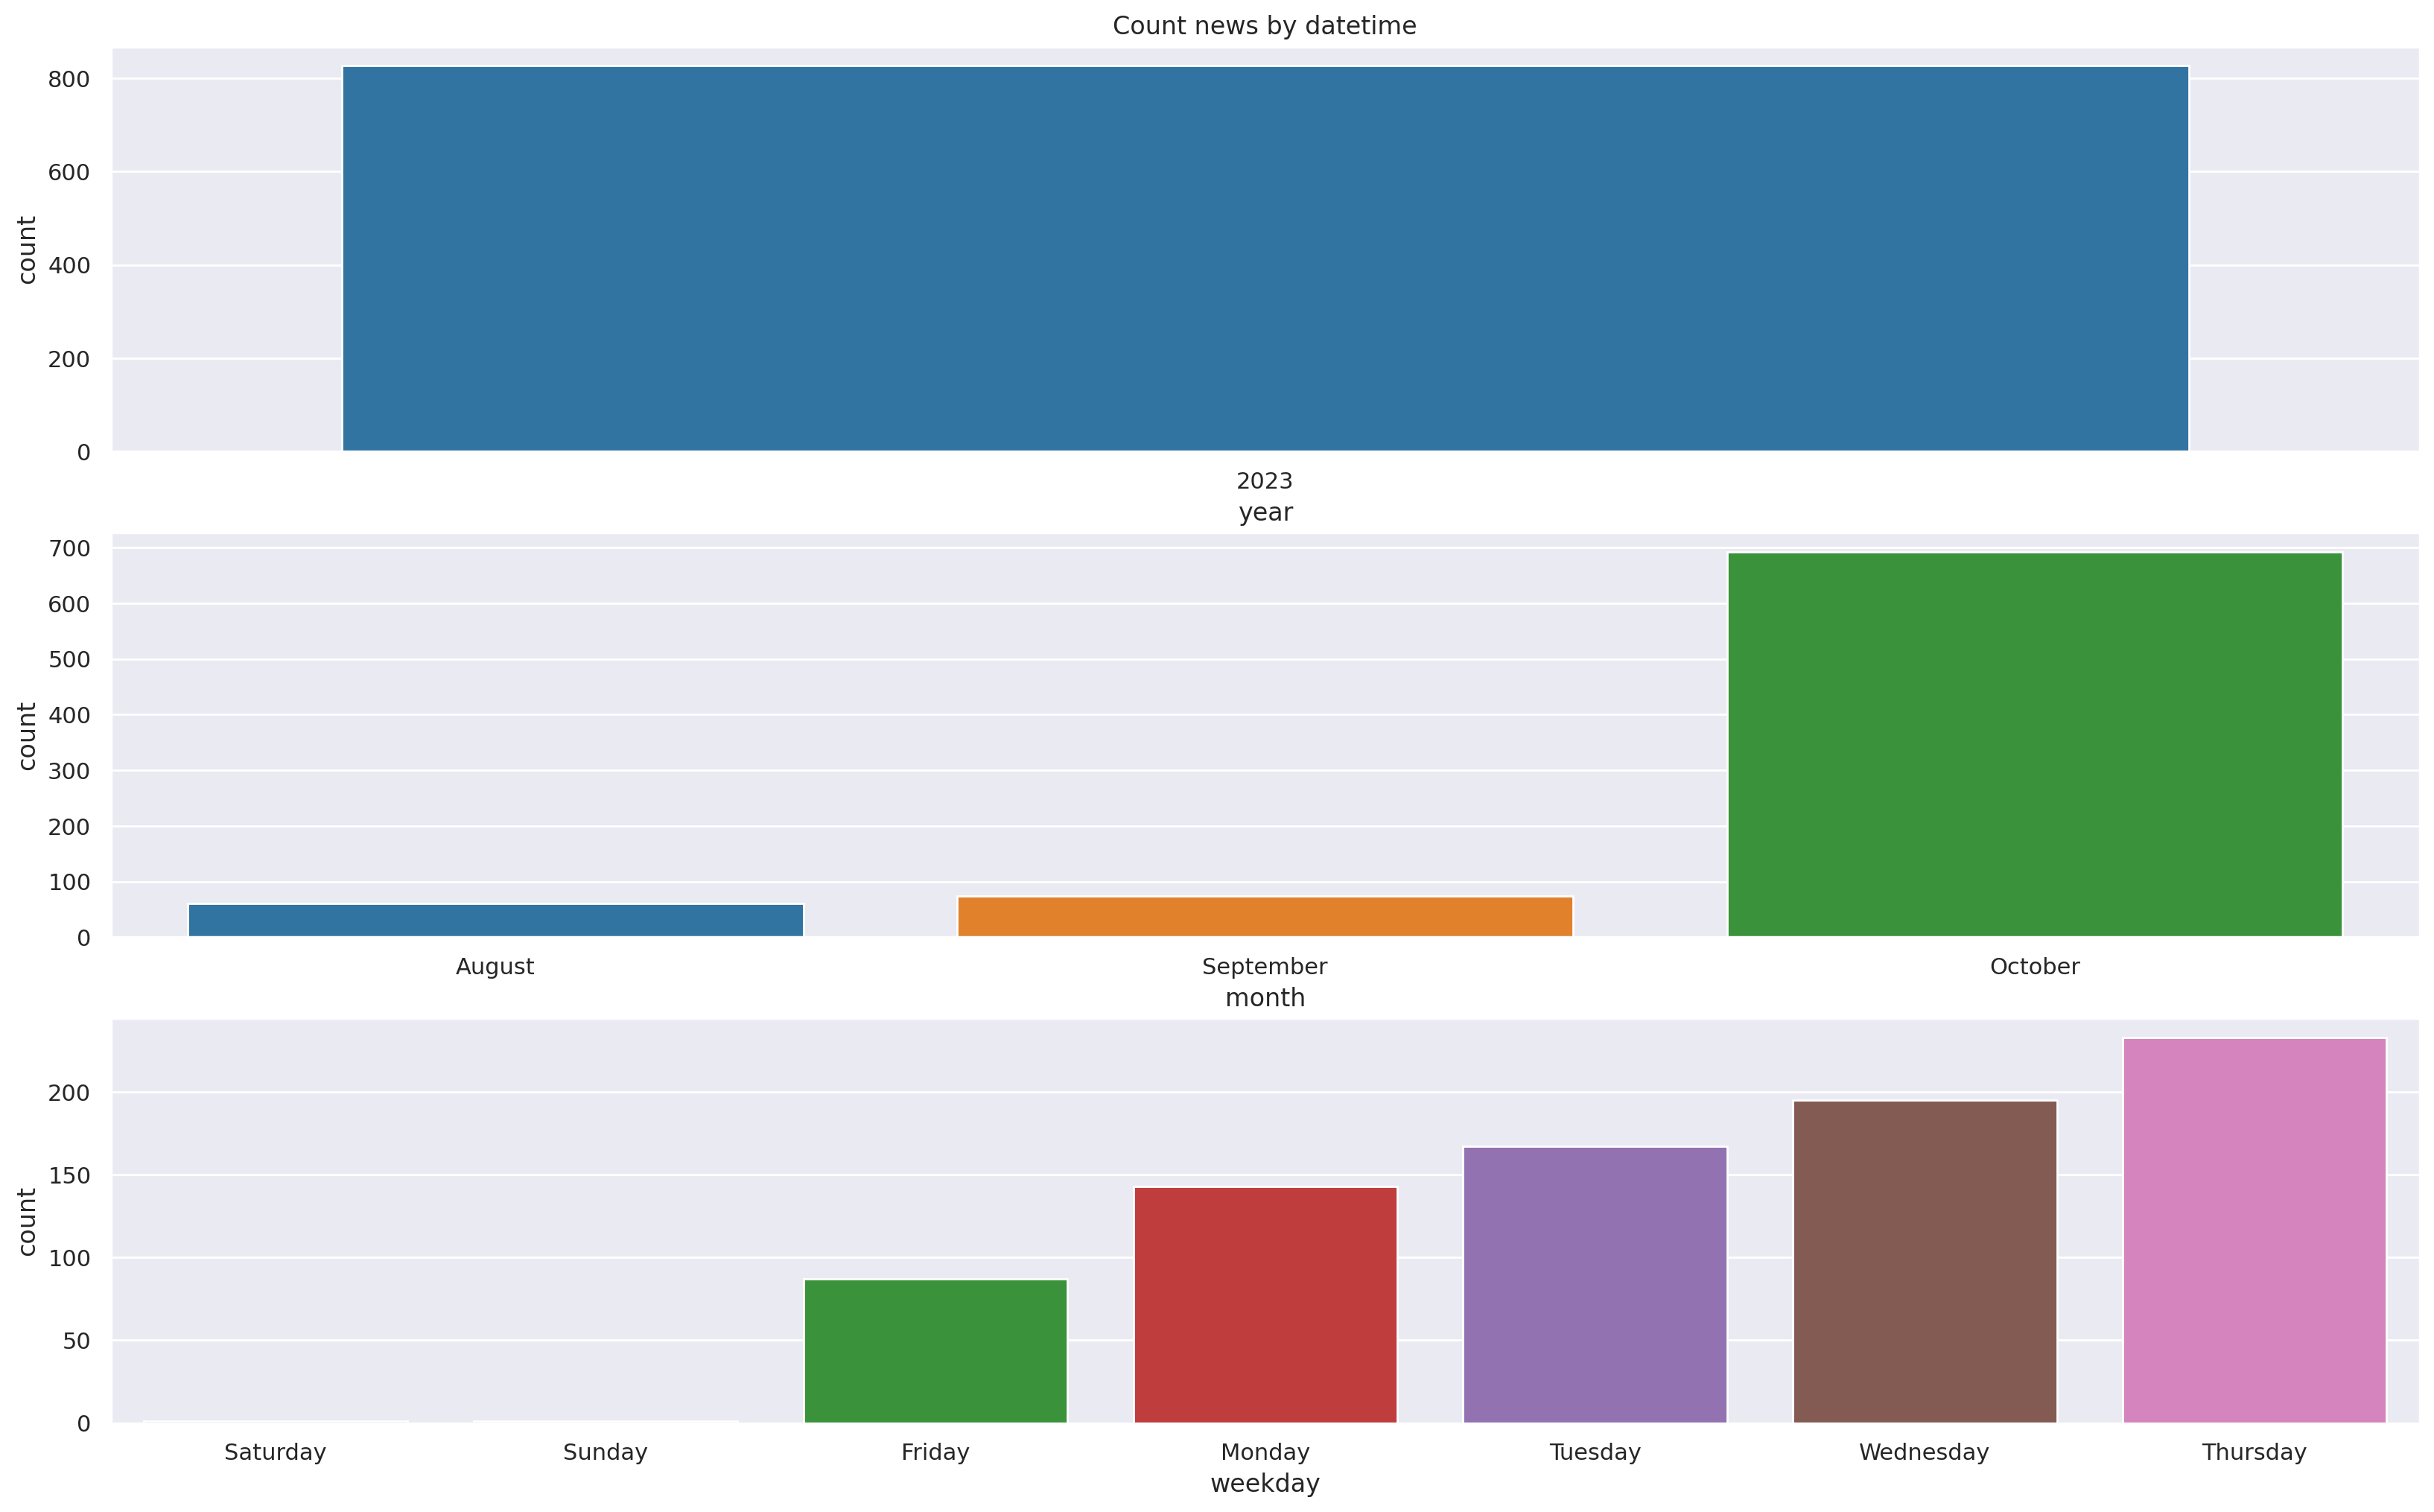

In [104]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(["year", "month", "weekday"]):
    sns.countplot(
        x=df[col],
        palette="tab10",
        ax=axs[ind],
        order=df[col].value_counts(ascending=True).index,
    )
axs[0].set_title("Count news by datetime");

Количество слов в статьях разных тематик примерно одинаковое.

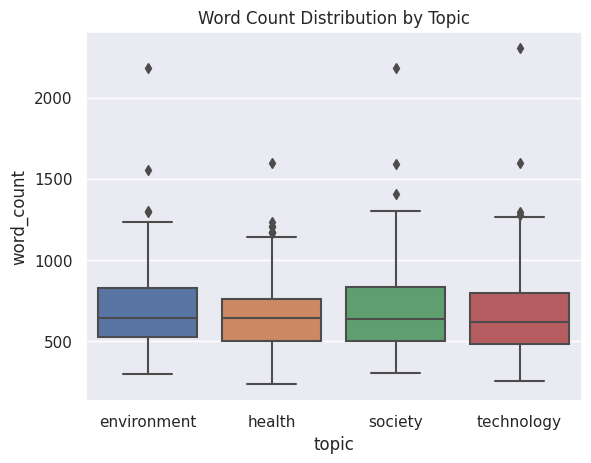

In [105]:
df["word_count"] = df["content"].apply(lambda x: len(str(x).split()))
sns.boxplot(x="topic", y="word_count", data=df)
plt.title("Word Count Distribution by Topic")
plt.show()

In [106]:
df.groupby("topic")["word_count"].describe()

count        mean         std    min     25%    50%     75%  \
topic                                                                      
environment  212.0  690.943396  249.033728  296.0  521.50  639.5  827.25   
health       212.0  653.014151  209.867132  232.0  496.75  641.5  761.50   
society      212.0  682.193396  250.789588  302.0  501.75  636.5  831.25   
technology   191.0  668.408377  268.094486  254.0  480.50  620.0  794.50   

                max  
topic                
environment  2184.0  
health       1596.0  
society      2184.0  
technology   2303.0

Посчитаем длину заголовков и основного текста.

In [107]:
df["len_title"] = df["title"].str.len()
df["len_content"] = df["content"].str.len()

Посмотрим, как они выглядят в разрезе каждой категории.

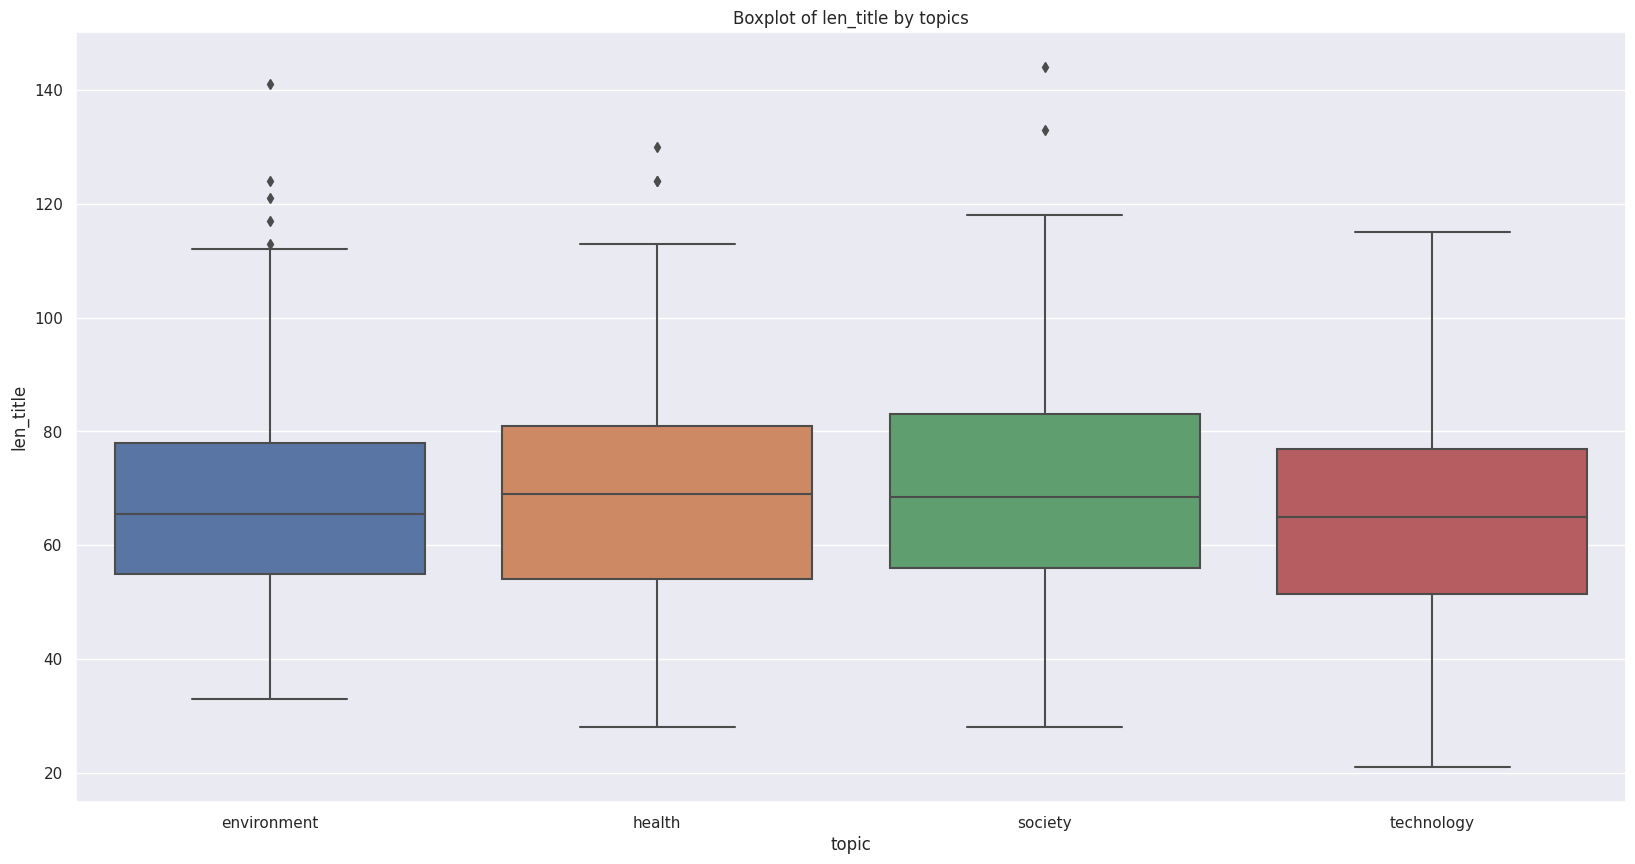

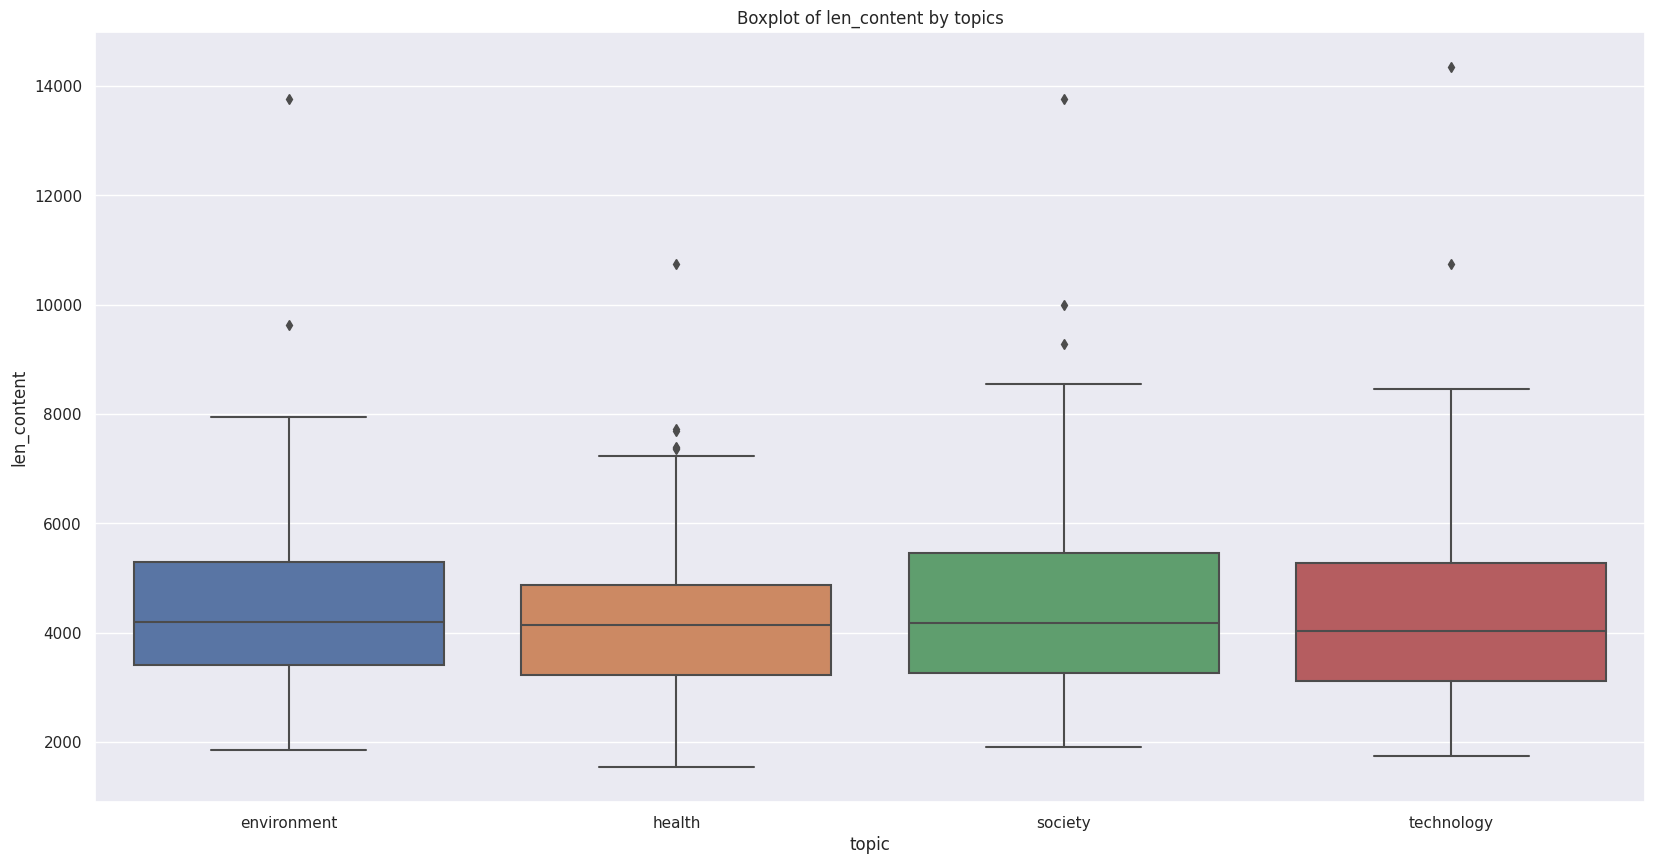

In [108]:
for col in ["len_title", "len_content"]:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
    sns.boxplot(x="topic", y=col, data=df, ax=ax)
    plt.title(f"Boxplot of {col} by topics");

Что можно заметить:
- В среднем длина заголовка по всем категориям около 68 символов
- Длина текста имеет незначительные хвосты

Посмотрим, какие ключевые слова чаще всего встречаются в статьях каждой тематики. Одной из гипотез является то, что статьи разных, но при этом близких тематик с одинаковыми ключевыми словами могут вносить негативный вклад в работу модели.

In [55]:
stop_words = stopwords.words("english")
stop_words.extend(
    [
        "new",
        "researcher",
        "researchers",
        "scientists",
        "study",
        "find",
        "show",
        "finds",
        "research",
    ]
)

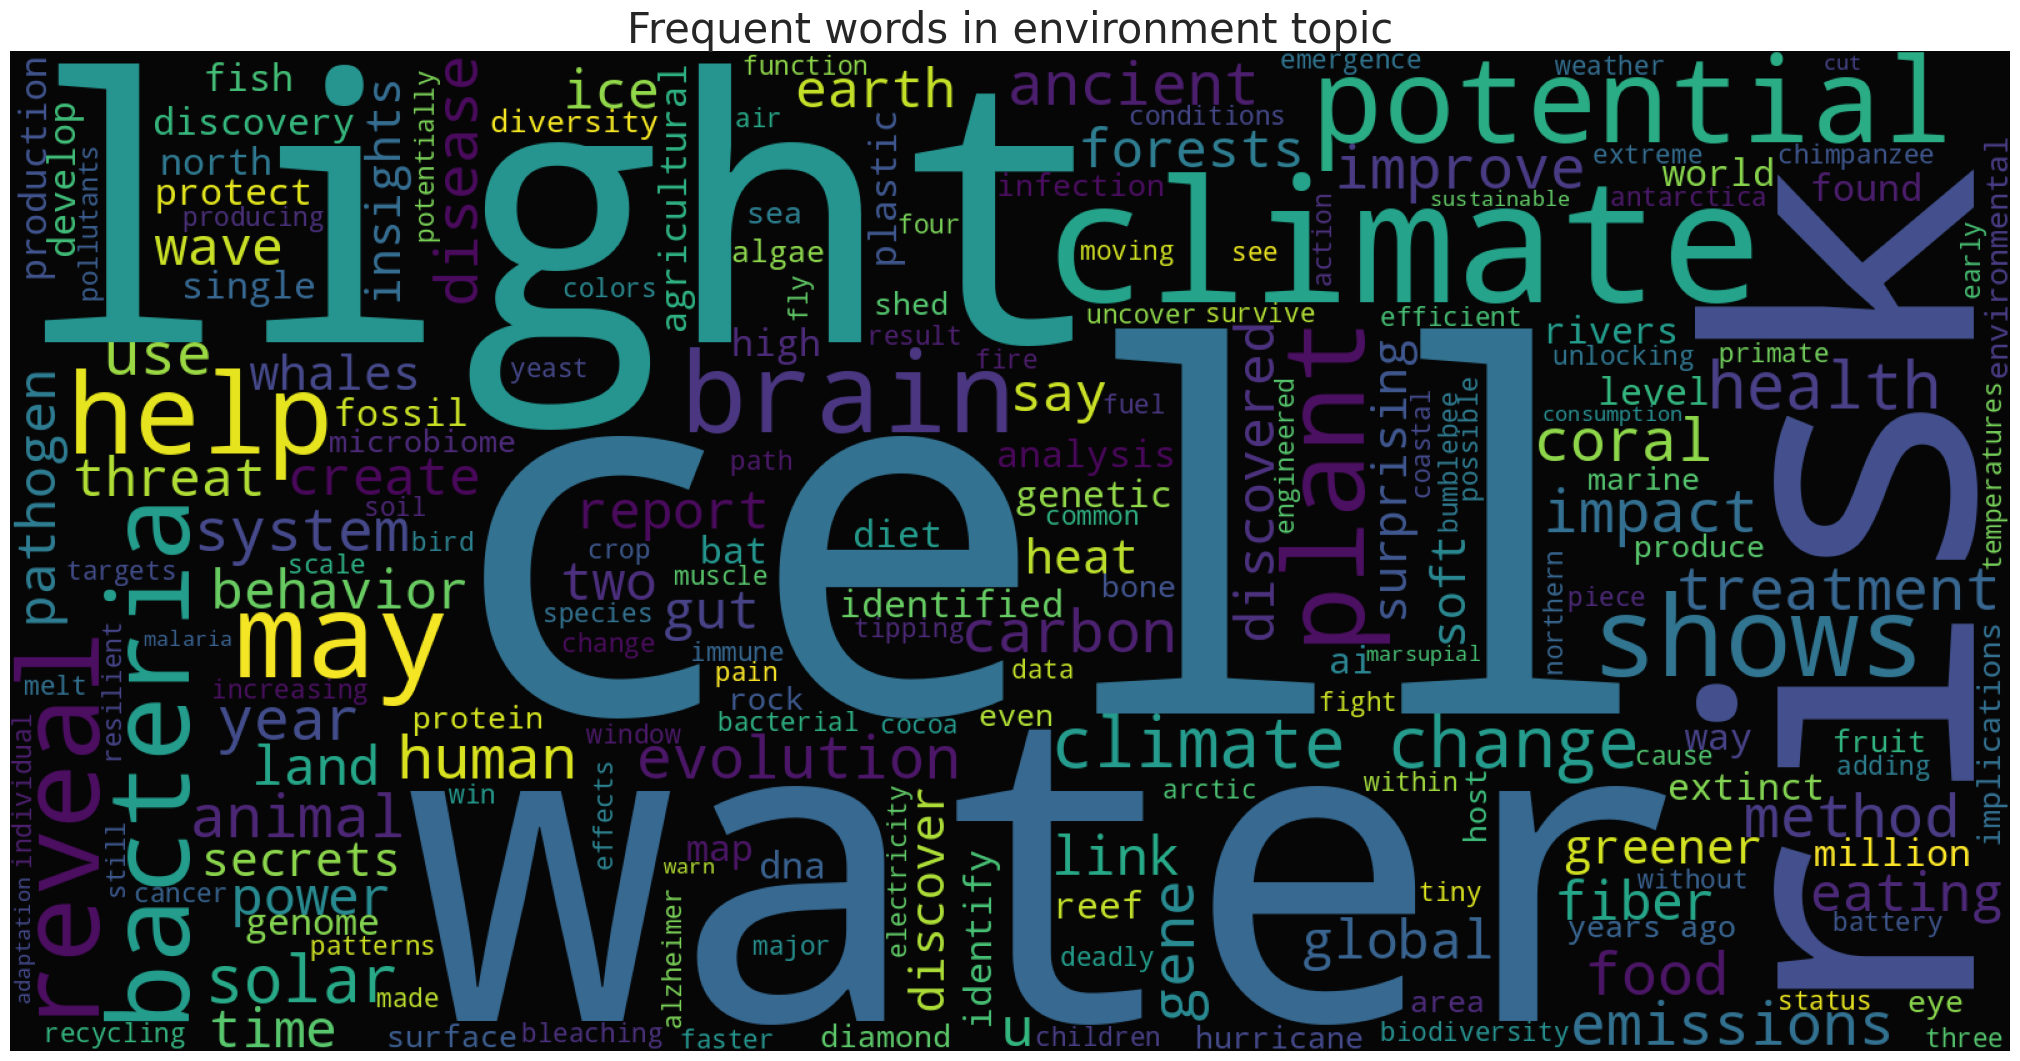

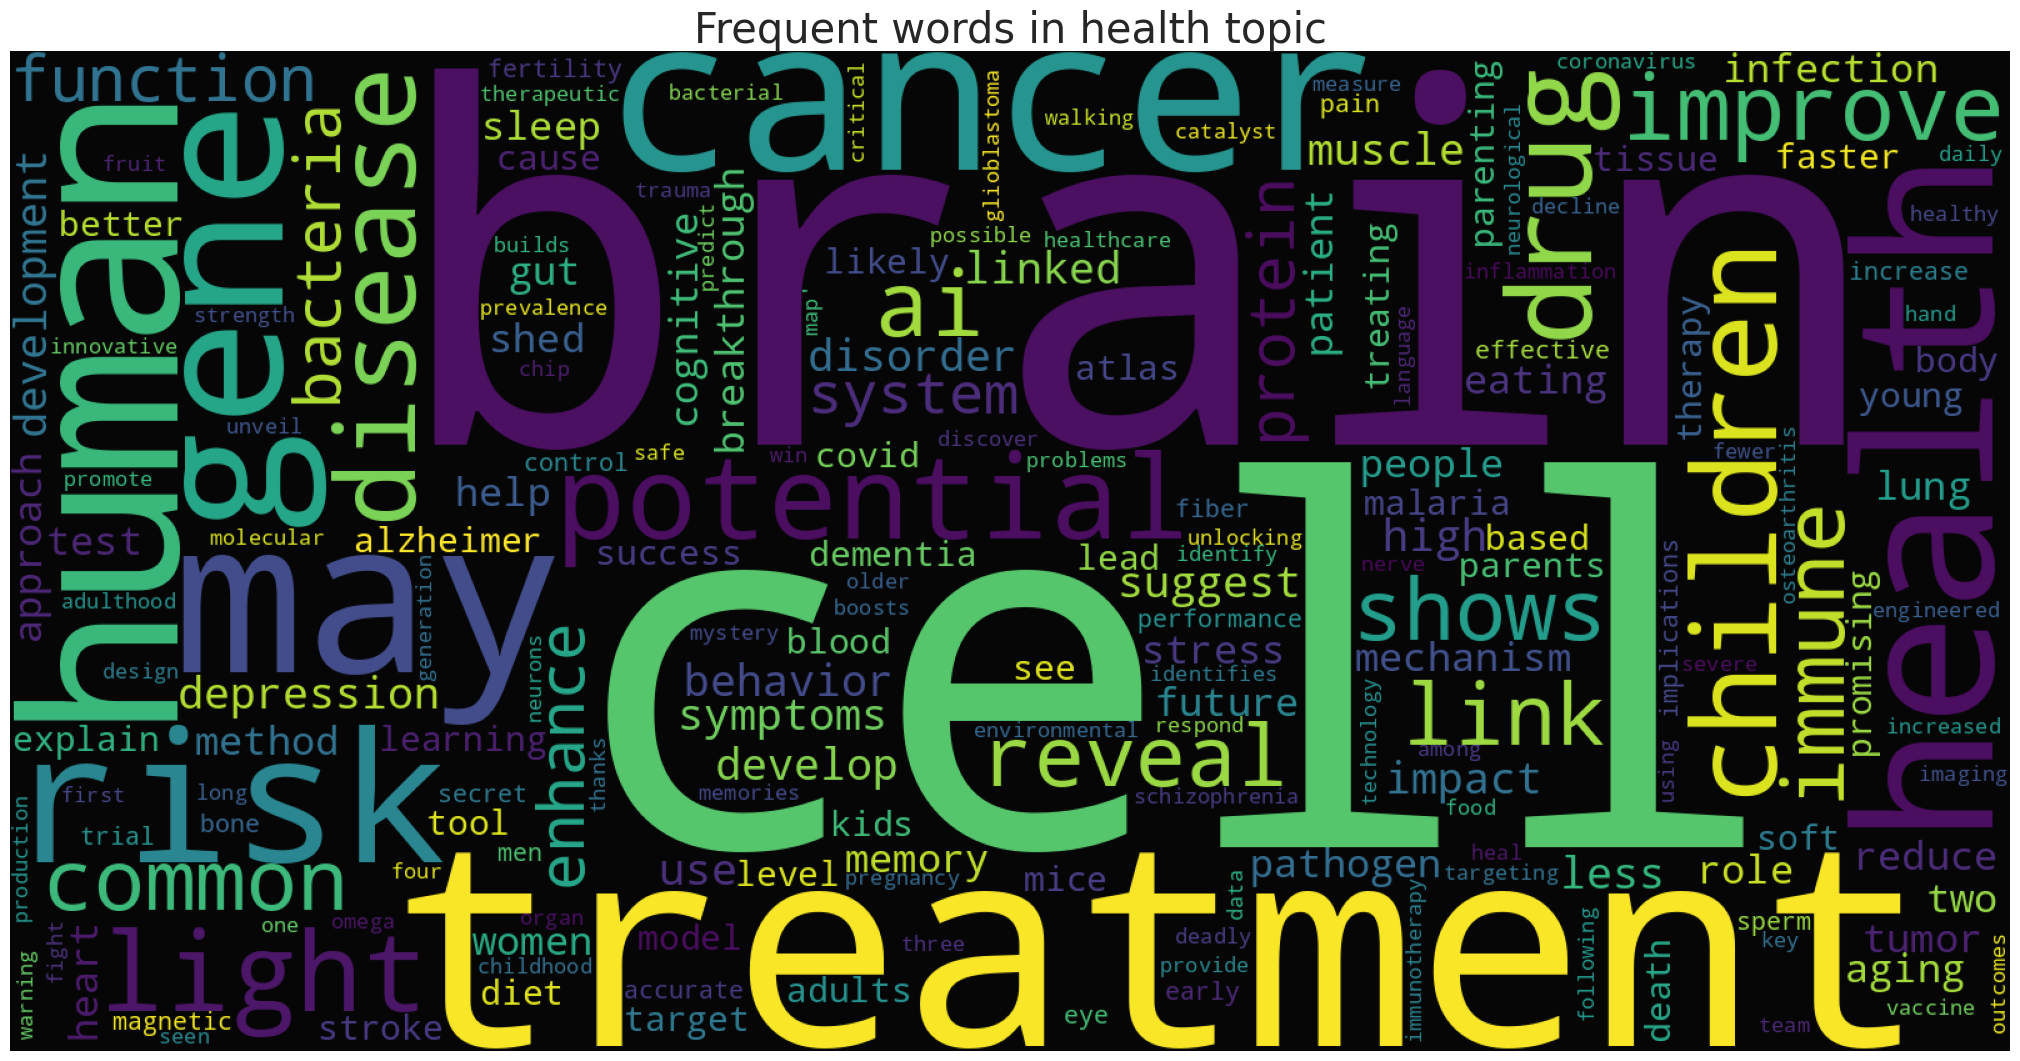

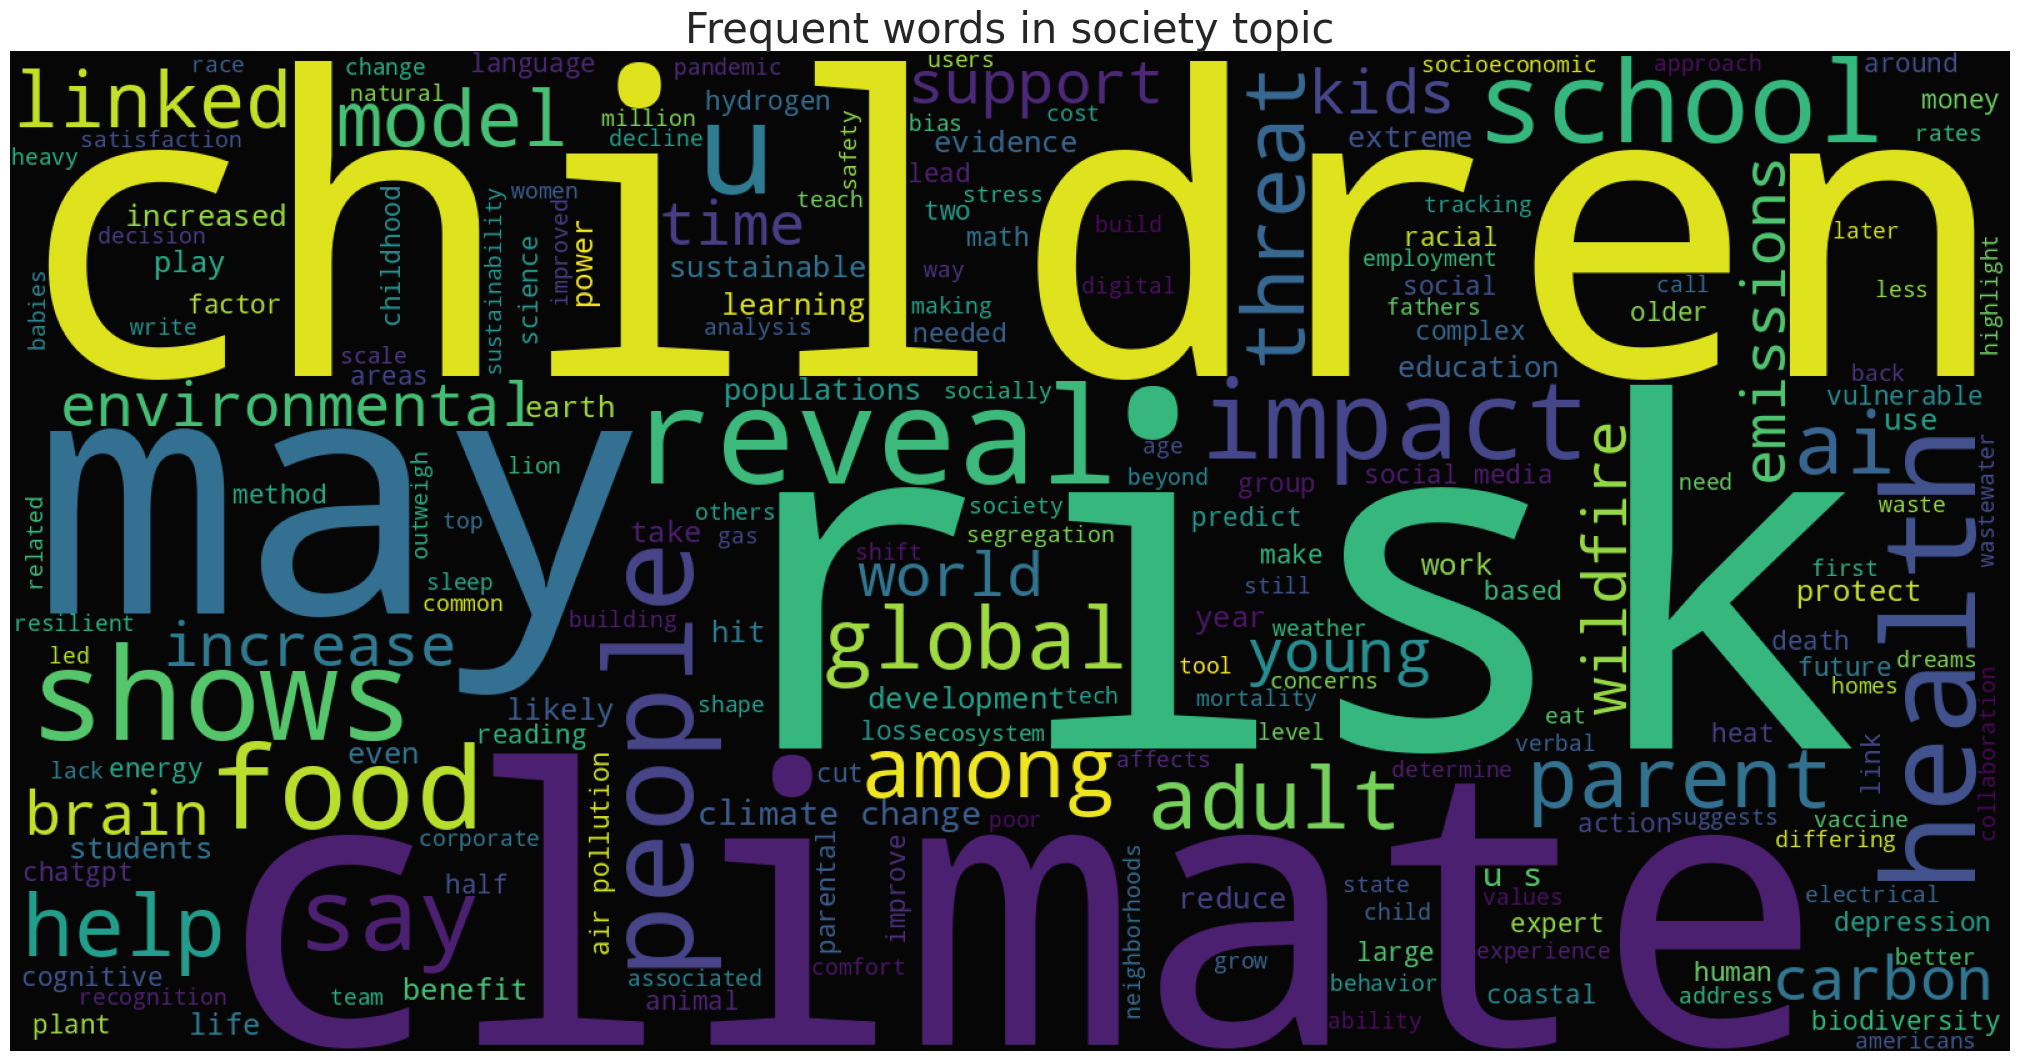

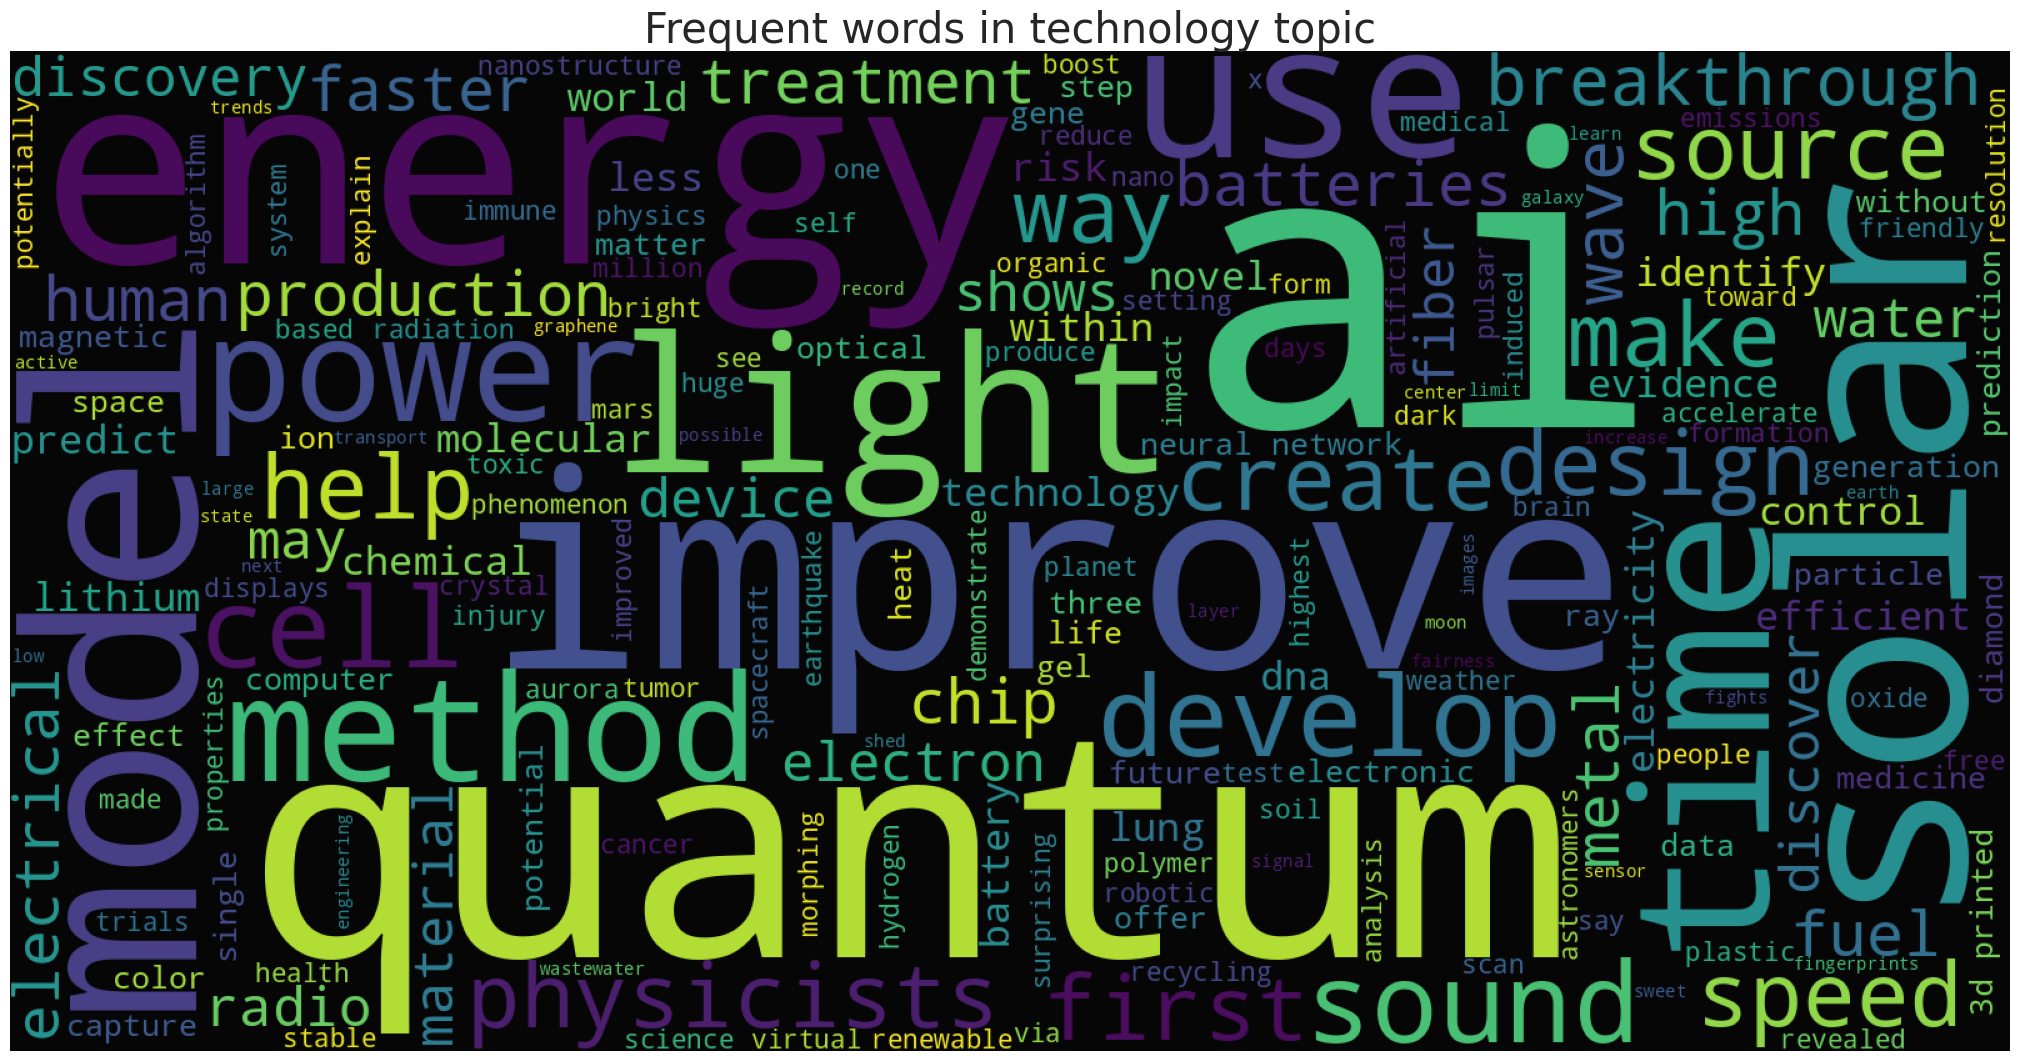

In [56]:
for topic in df.topic.unique():
    words = df[df.topic == topic].title.str.split(" ").explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in {topic} topic", fontsize=30)
    ax.imshow(wc, alpha=0.98)

Посмотрим на распределение данных по странам источника статьи в случае, если источник является университетом.

In [110]:
df["source_info"] = df["source"].apply(
    lambda x: requests.get(f"http://universities.hipolabs.com/search?name={x}").json()
)

In [139]:
df["source_country"] = df["source_info"].apply(
    lambda x: x[0]["country"] if x and len(x) > 0 and "country" in x[0] else "Not found"
)

In [141]:
df["source_country"].value_counts()

Not found         402
United States     203
United Kingdom     90
Japan              29
Australia          29
Canada             21
Sweden             12
Finland            10
New Zealand         6
Germany             5
Singapore           4
Switzerland         3
Hong Kong           3
Netherlands         3
Ireland             2
Denmark             2
Lithuania           2
Ghana               1
Name: source_country, dtype: int64

Какие выводы можно сделать по графику ниже - из статей, для которых была определена страна:
- Почти половина статей приходится на Unites States
- Порядка 70% статей приходится на англоговорящие страны

---



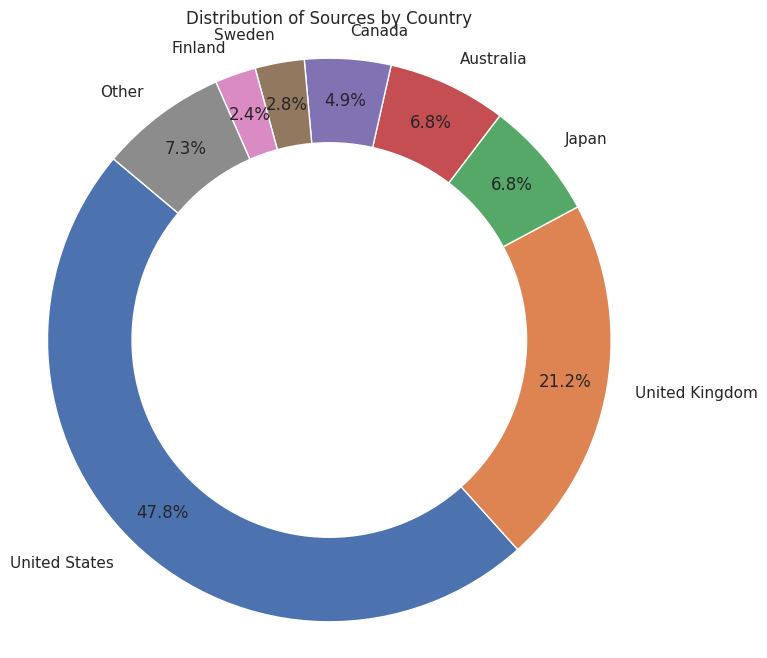

In [124]:
country_counts = df["source_country"].value_counts()

# Filter out countries with a percentage above a certain threshold (e.g., 2%)
threshold = 10  # You can adjust this value
filtered_country_counts = country_counts[country_counts >= threshold]

# Calculate the count for the "Other" category
other_count = country_counts[country_counts < threshold].sum()

# Create a list of labels including the "Other" category
labels = list(filtered_country_counts.index)
labels.append("Other")

# Create a list of sizes including the count of the "Other" category
sizes = list(filtered_country_counts.values)
sizes.append(other_count)

# Plot the donut chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, pctdistance=0.85)

# Draw a white circle at the center to create a donut chart
center_circle = plt.Circle((0, 0), 0.70, fc="white")
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.title("Distribution of Sources by Country")

# Display the donut chart
plt.axis("equal")
plt.show()

### Выводы

На данном этапе проведен первичный анализ датасета. При исключении дубликатов статьи распределены по тематикам неравномерно. Количество уникальных новостей менее 1000. В качестве дальнейших шагов можно рассмотреть сбор дополнительных данных (выгрузка данных с некоторой периодичностью, использование других источников) и синтез данных для классов с малой долей в выборке.

Все новости относятся к 2023 году, больше всего новостей в текущем месяце (Октябрь), так как выгружались последние новости в топе. В выходные (Суббота, Воскресенье) новости не публикуются. Количество новостей увеличивается с Понедельника по Четверг (пик), меньше всего новостей в Пятницу.

Количество слов в статьях разных тематик примерно одинаковое. В среднем длина заголовка по всем категориям около 68 символов. Длина текста имеет незначительные хвосты.

Проанализированы основные ключевые слова, которые наводят на гипотезу о том, что статьи разных тематик могут быть сильно похожи по доминирующим ключевым словам и тем самым негативно влиять на модель. Это необходимо учесть при построоении модели.

Поскольку мы работаем с текстами, на этом этапе пока не столь очевидно, какие данные и по какой причине стоит считать выбросами, а какие - особенностями конкретной тематики. Поэтому это будет рассмотрено на следующих этапах работы над проектом.

[github_repo](https://github.com/khadelya/nlp-project)